To run the notebook, you must install skfeature:

`pip3 install skfeature-chappers`

To install skfeature-chapper.

In [1]:
import generate_data as gd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectPercentile
from sklearn.preprocessing import MinMaxScaler
from skfeature.function.similarity_based import fisher_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
X,y = gd.gaussian_clusters(nr_features=10, nr_classes=5, nr_data_points=1000)

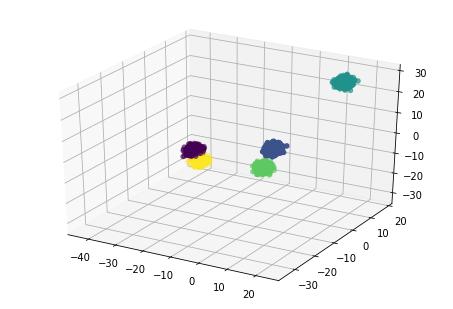

In [3]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X[:,0], X[:,1], X[:,2], c=y)
plt.show()

### F-score

In [4]:
fscore = f_classif(X,y)
print(fscore)

(array([6.32736165e+05, 3.55036176e+05, 4.92142179e+05, 4.68333270e+05,
       1.05114244e+06, 7.97924446e+09, 2.57271938e+09, 2.16230245e+09,
       1.29827761e+09, 5.45618636e+09]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


### Mutual Information

In [5]:
mi = mutual_info_classif(X,y)
print(mi)

[1.60951466 1.28291291 1.58273236 1.43199949 1.60983799 1.60983799
 1.60983799 1.60983799 1.60983799 1.60983799]


### Chi Squared

We need to normalize the data before using Chi Squared

In [6]:
scaler = MinMaxScaler()
scaler.fit(X)
X_normalized = scaler.transform(X)
chi = chi2(X_normalized,y)
print(chi)

(array([1062.65357316,  841.92095284, 1037.64072062, 1224.4987355 ,
        873.47833948, 1821.69514776, 1535.77832317, 1561.63573279,
       1974.87029662, 1432.82670691]), array([9.41644168e-229, 6.37470021e-181, 2.48332582e-223, 7.78242861e-264,
       9.28547151e-188, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 5.26505955e-309]))


### Fisher Score

In [10]:
fisher = fisher_score.fisher_score(X,y)
print(fisher)